# Stock Price Prediction with Milvus

Attempting to predict stock market prices is a common goal of machine learning models. In this notebook, we will examine several methods of predicting stock prices, and how we can make use of [Milvus](https://milvus.io) as part of our models. 

## Summary
[Long-Short Term Models (LSTM)](https://en.wikipedia.org/wiki/Long_short-term_memory) are a type of recurrent neural network which excels as processing time-series data. Due to this, it is a commonly chosen model for stock market analysis, as stock market trends are a form of time-series data. LSTMs are often trained on a singular time-series set.

In this project, we combine LSTM models and Milvus as a form of [Ensemble Learning](https://en.wikipedia.org/wiki/Ensemble_learning) to reduce over-fitting. After selecting a target stock and time period, we leverage Milvus to find similar stock time periods from our historical data. We then use classifiers trained on each stock to create predictions for our target stock, combined using a weighted average into a single prediction. 

### Requirements
To run this project, you'll need a Milvus 1.1.0 server and a MySQL server. We use Milvus to store and search vector embeddings of stocks; we use MySQL to store file path and timeframe data for each entry in Milvus.

Setup the Milvus and MySQL servers seperately, or run the two cells below to set up fresh servers with Docker.

In [20]:
! docker run --name milvus_cpu_1.1.0 -d \
-p 19530:19530 \
-p 19121:19121 \
milvusdb/milvus:1.1.0-cpu-d050721-5e559c

docker: Error response from daemon: Conflict. The container name "/milvus_cpu_1.1.0" is already in use by container "565a57fc80a3467f9be76d93b8ec494121726221c5318fb1fd473d13926390b0". You have to remove (or rename) that container to be able to reuse that name.
See 'docker run --help'.


In [21]:
! docker run -p 3306:3306 -e MYSQL_ROOT_PASSWORD=123456 -d mysql:5.7

f3189d31e4e74672bd632a897c594cc00885e5523a868a1c9f1592e73cf5418b
docker: Error response from daemon: driver failed programming external connectivity on endpoint peaceful_golick (210a75b4607af42feb710448499f7c4b061d33c31548ecf299f73cf92eebcb2d): Bind for 0.0.0.0:3306 failed: port is already allocated.


### Dataset
This project makes use of the [Huge Stock Market Dataset (HSMC)](https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs), which contains historical daily data from U.S. based stocks traded on NYSE and  NASDAQ. Download and extract the dataset to the same directory as this notebook.

### Python Imports
We make use of pandas, numpy, and sklearn to process our data. We use Keras to build our models.

In [241]:
import os
import pandas as pd
import numpy as np
import pymysql
from milvus import Milvus, MetricType
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import date
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, LSTM
from keras import initializers

### Configuration

Configuration variables for our project.

In [19]:
#config settings
STOCK_METRIC = 'Close'
STOCK_WIDTH = 20
STOCK_TIME_STEP = 5

DATASET_PATH = "data/archive/Stocks"
MILVUS_HOST = '127.0.0.1'
MILVUS_PORT = 19530
MILVUS_COLLECTION_NAME = 'stock_historical'
INDEX_FILE_SIZE = 1024
METRIC_TYPE = MetricType.IP

MYSQL_HOST = '127.0.0.1'
MYSQL_PORT = 3306
MYSQL_USER = 'root'
MYSQL_PWD = '123456'
MYSQL_DB = 'mysql'
MYSQL_TABLE = 'milvus_stock_search'

In [22]:
def read_from_file(path):
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
    df['Date'] = df['Date'].apply(lambda x: x.date())
    df.index = df['Date']
    df = df[[STOCK_METRIC]]
    return df

In [23]:
#df = read_from_file('data/archive/Stocks/evlmc.us.txt')

In [24]:
def partition_data(df, duration, time_step):
    stock_sets, date_starts, date_ends = [], [], []
    for i in range(0,len(df) - duration,time_step):
        stock_set = df.iloc[i:i + duration]
        scaler = StandardScaler()
        scaled_stock_set = scaler.fit_transform(stock_set)
        stock_sets.append(np.stack(scaled_stock_set, axis=1).tolist()[0])
        date_starts.append(df.index[i])
        date_ends.append(df.index[i + duration])
    return stock_sets, date_starts, date_ends

In [25]:
#sets, start, end = partition_data(df, STOCK_WIDTH, STOCK_TIME_STEP)
#type(sets[0])
#sets

list

In [26]:
def training_validation_split(df, split_size):
    return df.iloc[:-split_size], df.iloc[-split_size:]

### Database Management
We create new tables and collections in our databases to hold our data.

If you need to reset the databases, uncomment the cell below. Please use caution to avoid deleting important data. 

In [231]:
##Uncomment the code in this cell to delete Milvus collections and MySQL tables.
##WARNING: Use this with caution

#cursor.execute("DROP table milvus_stock_search;")
#client.drop_collection(collection_name=MILVUS_COLLECTION_NAME)  


In [27]:
def load_data_to_mysql(data):
    sql = "insert into " + MYSQL_TABLE + " (milvus_id,file_path,start_date,end_date) values (%s,%s,%s,%s);"
    cursor.executemany(sql, data)
    conn.commit()

In [28]:
client = Milvus(host=MILVUS_HOST, port=MILVUS_PORT)
try:
    if not client.has_collection(MILVUS_COLLECTION_NAME)[1]:
        collection_param = {
            'collection_name': MILVUS_COLLECTION_NAME,
            'dimension': STOCK_WIDTH,
            'index_file_size': INDEX_FILE_SIZE,
            'metric_type': METRIC_TYPE
        }
        status = client.create_collection(collection_param)
        if status.code != 0:
            raise Exception(status.message)
except Exception as e:
    print("Failed to load data to Milvus: {}".format(e))

In [29]:
conn = pymysql.connect(host=MYSQL_HOST, user=MYSQL_USER, port=MYSQL_PORT, 
                       password=MYSQL_PWD, database=MYSQL_DB, local_infile=True)
cursor = conn.cursor()
sql = "create table if not exists " + MYSQL_TABLE + "(milvus_id BIGINT NOT NULL PRIMARY KEY, file_path TEXT, start_date DATE, end_date DATE);"
try:
    cursor.execute(sql)
except Exception as e:
    print("MYSQL ERROR: {} with sql: {}".format(e, sql))

### Load Stock Data into Milvus and MySQL

Generate vector embeddings for time-series data and store in Milvus and MySQL.

Some stocks may fail to process due to incomplete data in the dataset.

In [ ]:
directory = os.fsencode(DATASET_PATH)
test_splits = []
for file in os.listdir(directory):
#for file in ['data/archive/Stocks/evlmc.us.txt']:
    filename = os.fsdecode(file)
    if filename.endswith(".txt"): 
        try:
            #full_path = os.path.join(directory, file)
            full_path = DATASET_PATH + '/' + filename
            #full_path = 'data/archive/Stocks/evlmc.us.txt'
            #print(full_path)
            df = read_from_file(full_path)
            training_df, test_df = training_validation_split(df, STOCK_WIDTH)
            test_splits.append(test_df)
            sets, start, end = partition_data(training_df, STOCK_WIDTH, STOCK_TIME_STEP)
            #print(type(start[0]))
            status, ids = client.insert(collection_name=MILVUS_COLLECTION_NAME, records=sets)
            if not status.OK():
                print("Insert failed for file {}: {}".format(full_path, status))
                continue
            #ids = list(map(str, ids))
            #print(list(zip(ids, [full_path] * len(ids), start, end)))
            load_data_to_mysql(zip(ids, [full_path] * len(ids), start, end))
            #break
        except Exception as e:
            print("Failed to load data for file {}: {}".format(full_path, e))
            continue
    else:
        continue

In [232]:
#cursor.execute("SELECT * FROM milvus_stock_search WHERE file_path NOT LIKE '%evlmc%' LIMIT 10;")
#result = cursor.fetchall()
#print(result)

In [33]:
#cursor.execute("DROP table milvus_stock_search;")
#client.drop_collection(collection_name=MILVUS_COLLECTION_NAME)  
# fetch all the matching rows 

In [34]:
#len(test_splits)

3482

In [234]:
#cursor.execute("SELECT * FROM milvus_stock_search WHERE milvus_id = '1625592026564694001';")
#result = cursor.fetchall()
#print(result)
#result[0]

Check number of entries in the MySQL database.

In [255]:
cursor.execute("SELECT COUNT(*) FROM milvus_stock_search;")
result = cursor.fetchall()
print(result)

((1429741,),)


### Data Retrieval

Helper functions to retrieve and clean data

In [235]:
def fetch_period(path, start=date(1900,1,1), end=date(2017,11,3), additional=0, starti = 0, scaler=None, fit_scaler=False):
    df = read_from_file(path)
    if start != date(1900,1,1) and starti == 0:
        starti = df.index.get_loc(start)
        
    endi = df.index.get_loc(end)
    df = df.iloc[starti:endi + additional]
    if scaler==None:
        scaler = StandardScaler()
        if additional > 0:
            scaler.fit(df.iloc[:-additional])
        else:
            scaler.fit(df)
    if fit_scaler:
        if additional > 0:
            scaler.fit(df.iloc[:-additional])
        else:
            scaler.fit(df)

    
    df[df.columns] = scaler.transform(df[df.columns])
    return df

In [37]:
def fetch_from_mysql(ids):
    data = []
    for milvus_id in ids:
        sql = "SELECT file_path, start_date, end_date FROM " + MYSQL_TABLE + " where milvus_id=" + str(milvus_id) + ";"
        cursor.execute(sql)
        data.append(cursor.fetchall()[0])
    return data

In [236]:
def clean_data(milvus_results, mysql_results, threshold):
    cleaned_milvus_results = []
    cleaned_mysql_results = []
    for milvus_row, mysql_row in zip(milvus_results[0], mysql_results):
        if read_from_file(mysql_row[0]).index.get_loc(mysql_row[1]) > threshold:
            cleaned_milvus_results.append(milvus_row)
            cleaned_mysql_results.append(mysql_row)
    return [cleaned_milvus_results], cleaned_mysql_results

### Searching Example

Let's take a look at a randomly selected stock, "AGU". The stock used can be adjusted by changing the "stock_filepath" variable in the cell below.

Using Milvus, we'll perform a search for the 10 most similar periods of stock history from our dataset. We perform our search using a period of 20 consecutive days. Our goal is to simulate predicting the 5 days after that.

In [247]:
stock_filepath = 'data/archive/Stocks/agu.us.txt'
start_date = date(2017,10,6)
end_date = date(2017,11,3)
query_data = [fetch_period(stock_filepath, start_date, end_date)['Close'].values.tolist()]
search_param = {'nprobe': 16}
status, results = client.search(collection_name=MILVUS_COLLECTION_NAME, query_records=query_data, top_k=10, params=search_param)
ids = [row.id for row in results[0]]
mysql_results = fetch_from_mysql(ids)
results, mysql_results = clean_data(results, mysql_results, 65)


In [139]:
print(type(ids[0]))
#display(results)
#display(mysql_results)

<class 'int'>


In [248]:
scaled_results = []
for mysql_row in mysql_results:
    df = fetch_period(mysql_row[0], mysql_row[1], mysql_row[2], 5)
    scaled_results.append(df)

distances = [row.distance for row in results[0]]
scaler = MinMaxScaler()
scaled_distances = scaler.fit_transform(np.array(distances).reshape(-1,1))
#print(scaled_distances)
distances = [1 / x for x in distances]
#print(distances)
weighted_avg = 0
predicted_points = np.zeros((5, 1))
#print(len(scaled_results))
for d, df in zip(distances, scaled_results):
    predicted_points = np.add(predicted_points, df[-5:].values * d)
predicted_points /= sum(distances)

### Plotting Search Results

We performed our search using 20 datapoints, but we will graph an extra 5 datapoints after that to show stock divergence.

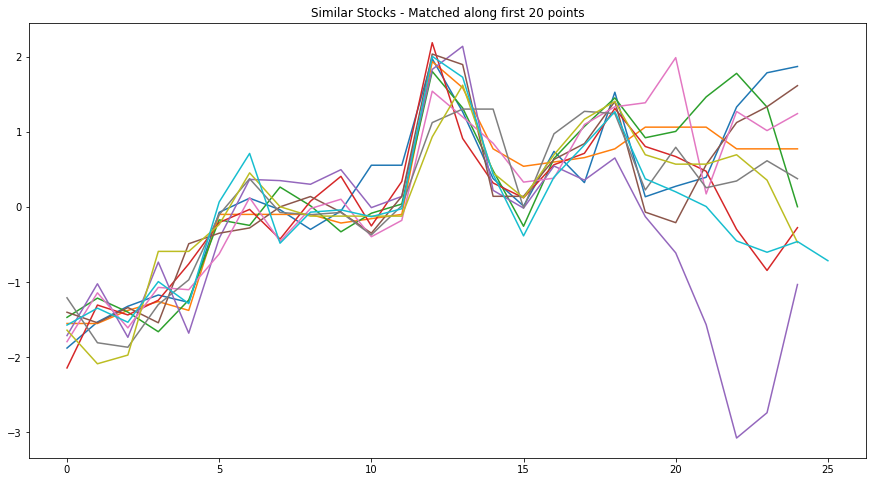

In [252]:

plt.figure(figsize=(15,8))
plt.title("Similar Stocks - Matched along first 20 points")
for row in mysql_results:
    df = fetch_period(row[0], row[1], row[2], 5)
    plt.plot(df[['Close']].values)

plt.plot(np.reshape(fetch_period(stock_filepath, start_date, end_date, 6)['Close'].values.tolist(), (26, 1)))

As we can see, since matching was only performed on the first 20 points, the stocks diverge greatly towards the end of the graphed section. Days 20-25 are our "prediction area", so this is less than ideal.

We generate an average of stocks in our "prediction area" and calculate a MSE.

MSE: 0.588420363789004


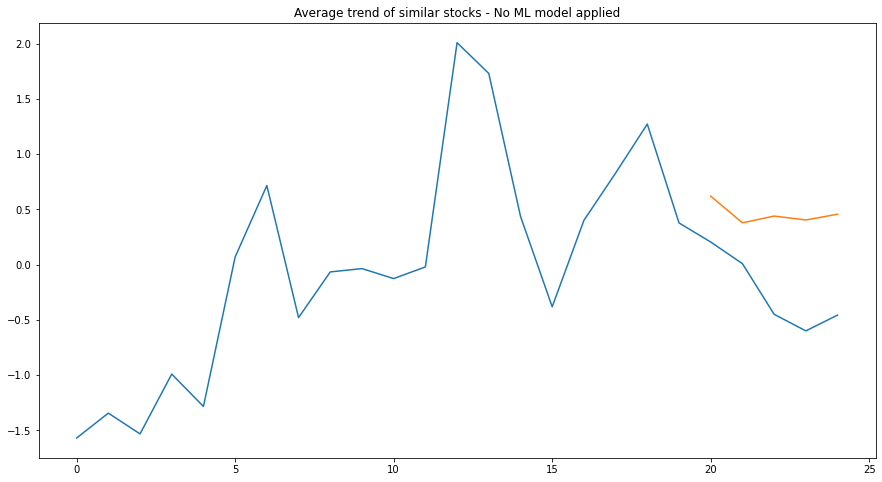

In [253]:
plt.figure(figsize=(15,8))
plt.title("Average trend of similar stocks - No ML model applied")
#display(np.shape(fetch_period(stock_filepath, start_date, end_date, 5)['Close'].values.tolist()))
original_points = np.reshape(fetch_period(stock_filepath, start_date, end_date, 5)['Close'].values.tolist(), (25, 1))
plt.plot(original_points)
plt.plot(range(20, 25), predicted_points)
print("MSE: " + str(mean_squared_error(original_points[-5:], predicted_points)))

As we can see, with a MSE of 0.588420363789004, prediction using purely a vector search has some flaws.

### LSTMs

Now we'll try analysis using a basic LSTM. Our model consists of three layers; two LSTM layers with 50 units each, and a Dense layer that serves to output a single prediction. We use our model by feeding in the preceeding 60 data points from a stock as our X input, with the next data point being the Y output. We use a MSE loss function to train our model. 

In [260]:
def build_model(path, end, fit_scaler=False):
    scaler = StandardScaler()
    scaled_data = fetch_period(path, end=end, scaler=scaler, fit_scaler=fit_scaler)
    x_train, y_train = [], []
    for i in range(60,len(scaled_data.values)):
        x_train.append(scaled_data.values[i-60:i,0])
        y_train.append(scaled_data.values[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)

    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True))
    model.add(LSTM(units=50))
    model.add(Dense(1,kernel_initializer=initializers.Ones(), trainable=True))

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)
    return model, scaler

We'll use the same stock as before and build a LSTM from it.

In [261]:
model, scalermain = build_model(stock_filepath, date(2017,11,3), fit_scaler=True)

3135/3135 - 41s - loss: 0.0101


In [269]:
inputs = fetch_period(stock_filepath, starti = -66, end=date(2017,11,3), additional=5, scaler=scalermain).values
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)

MSE: 0.0009756594704152591


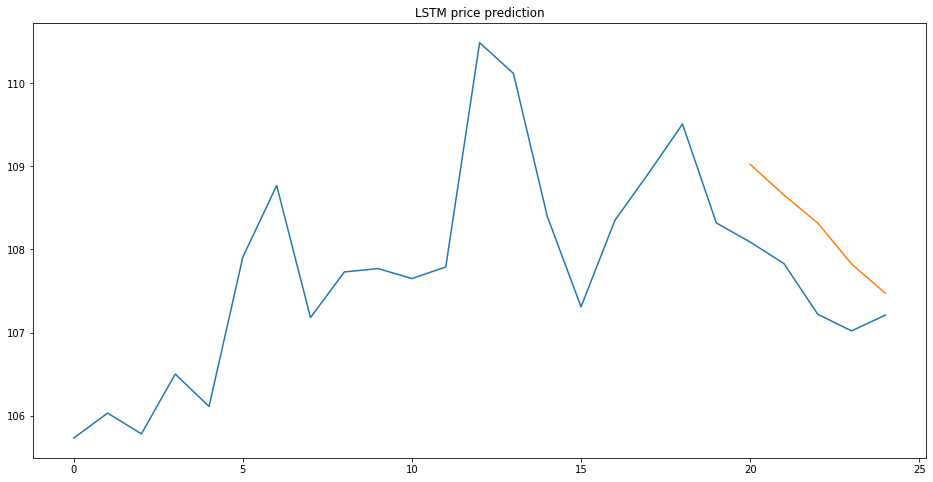

In [271]:
plt.figure(figsize=(16,8))
plt.title("LSTM price prediction")
original_points = inputs[-25:]
plt.plot(scalermain.inverse_transform(original_points))
plt.plot(range(20, 25), scalermain.inverse_transform(closing_price))
print("MSE: " + str(mean_squared_error(original_points[-5:], closing_price)))

As we can see, a LSTM performs quite well.

### Ensemble LSTM 

Now, we'll put together Milvus and LSTMs to create an ensemble learner. We'll train LSTM models on each of the searched stocks, using training points up until the search result period. 

NOTE: It is possible to pre-train models for faster queries, but doing so would massively increase the time required to set up this notebook.

In [217]:
models = []
scalers = []
for row in mysql_results:
    df = fetch_period(row[0], row[1], row[2], 5)
    model, scaler = build_model(row[0], row[2], fit_scaler=True)
    models.append(model)
    scalers.append(scaler)

False
scaler new
add
True
<class 'numpy.ndarray'>
(950, 1)
950
(890, 60)
(890,)
890/890 - 15s - loss: 0.0497
False
scaler new
add
True
<class 'numpy.ndarray'>
(240, 1)
240
(180, 60)
(180,)
180/180 - 5s - loss: 0.1901
False
scaler new
add
True
<class 'numpy.ndarray'>
(6510, 1)
6510
(6450, 60)
(6450,)
6450/6450 - 79s - loss: 0.0105
False
scaler new
add
True
<class 'numpy.ndarray'>
(2270, 1)
2270
(2210, 60)
(2210,)
2210/2210 - 31s - loss: 0.0274
False
scaler new
add
True
<class 'numpy.ndarray'>
(1790, 1)
1790
(1730, 60)
(1730,)
1730/1730 - 24s - loss: 0.0176
False
scaler new
add
True
<class 'numpy.ndarray'>
(2785, 1)
2785
(2725, 60)
(2725,)
2725/2725 - 36s - loss: 0.0137
False
scaler new
add
True
<class 'numpy.ndarray'>
(230, 1)
230
(170, 60)
(170,)
170/170 - 5s - loss: 0.2655
False
scaler new
add
True
<class 'numpy.ndarray'>
(1050, 1)
1050
(990, 60)
(990,)
990/990 - 15s - loss: 0.0348
False
scaler new
add
True
<class 'numpy.ndarray'>
(7505, 1)
7505
(7445, 60)
(7445,)
7445/7445 - 100s - l

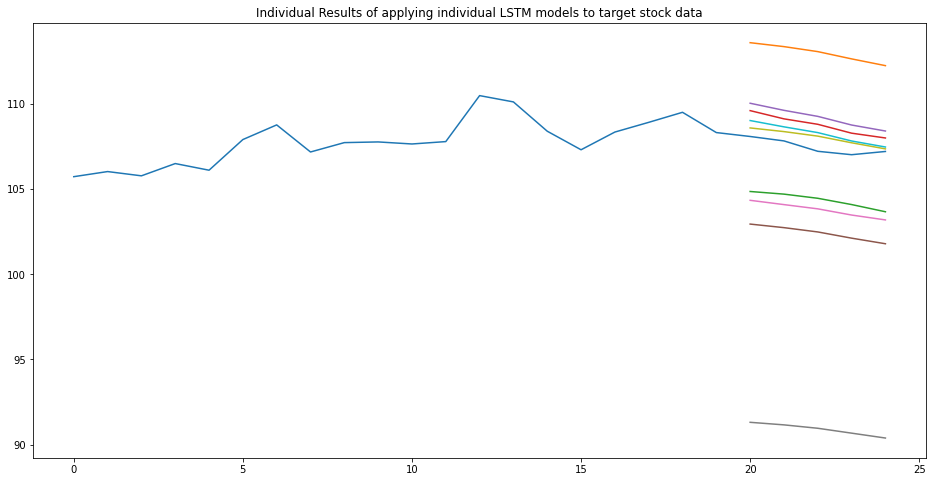

In [281]:

plt.figure(figsize=(16,8))
plt.title("Individual Results of applying individual LSTM models to target stock data")
plt.plot(scalermain.inverse_transform(np.reshape(fetch_period(stock_filepath, start_date, end_date, scaler=scalermain, additional=5)['Close'].values.tolist(), (25, 1))))

predicted_closing_prices_normalized = []
predicted_closing_prices = []
for model, scaler in zip(models, scalers):
    inputs = fetch_period(stock_filepath, starti = -66, end=date(2017,11,3), additional=5, scaler=scalermain).values
    X_test = []
    for i in range(60,inputs.shape[0]):
        X_test.append(inputs[i-60:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    predicted_closing_price_normalized = model.predict(X_test)
    predicted_closing_prices_normalized.append(closing_price)
    predicted_closing_price = scalermain.inverse_transform(predicted_closing_price_normalized)
    predicted_closing_prices.append(predicted_closing_price)
    plt.plot(range(20, 25), predicted_closing_price)

Next, we'll discard outliers based on [Interquartile range](https://en.wikipedia.org/wiki/Interquartile_range) and compute a weighted average to achieve a final result.

In [286]:
avg_predictions = np.average(predicted_closing_prices, axis=1)
q75, q25 = np.percentile(avg_predictions, [75 ,25])
iqr = q75 - q25

distances = [row.distance for row in results[0]]
total_distance = 0
predicted_points = np.zeros((5, 1))
predicted_points_norm = np.zeros((5, 1))
for d, data, data_norm in zip(distances, predicted_closing_prices, predicted_closing_prices_normalized):
    data_avg = np.average(data)
    if data_avg <= q75 + 1.5 * iqr and data_avg >= q25 - 1.5 * iqr:
        predicted_points = np.add(predicted_points, data * d)
        predicted_points_norm = np.add(predicted_points_norm, data_norm * d)
        total_distance += d
predicted_points /= total_distance
predicted_points_norm /= total_distance
#predicted_points
#for d, data in zip(distances, predicted_closing_prices):

MSE: 0.0009756593127969546


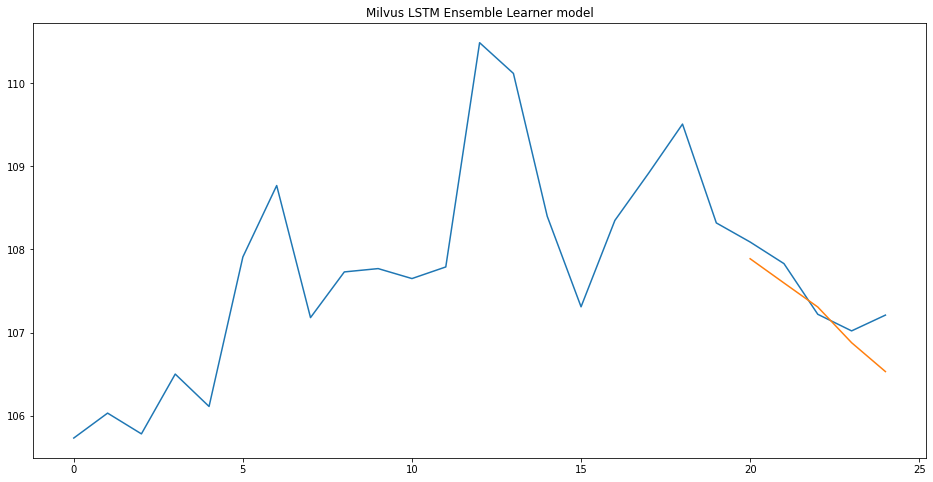

In [292]:
plt.figure(figsize=(16,8))
plt.title("Milvus LSTM Ensemble Learner model")
original_points = np.reshape(fetch_period(stock_filepath, start_date, end_date, scaler=scalermain, additional=5)['Close'].values.tolist(), (25, 1))
plt.plot(scalermain.inverse_transform(original_points))
plt.plot(range(20, 25), predicted_points)

print("MSE: " + str(mean_squared_error(original_points[-5:], predicted_points_norm)))

### Summary

With a MSE of 0.0009756593127969546, the ensemble model performs similarly to the singular LSTM with its MSE of 0.0009756594704152591. In summary, both models are valid options, a user may find use cases for either model depending on their goals of specificity or generalization. 